c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cpu
Import Completed
torch.Size([3, 600, 900])


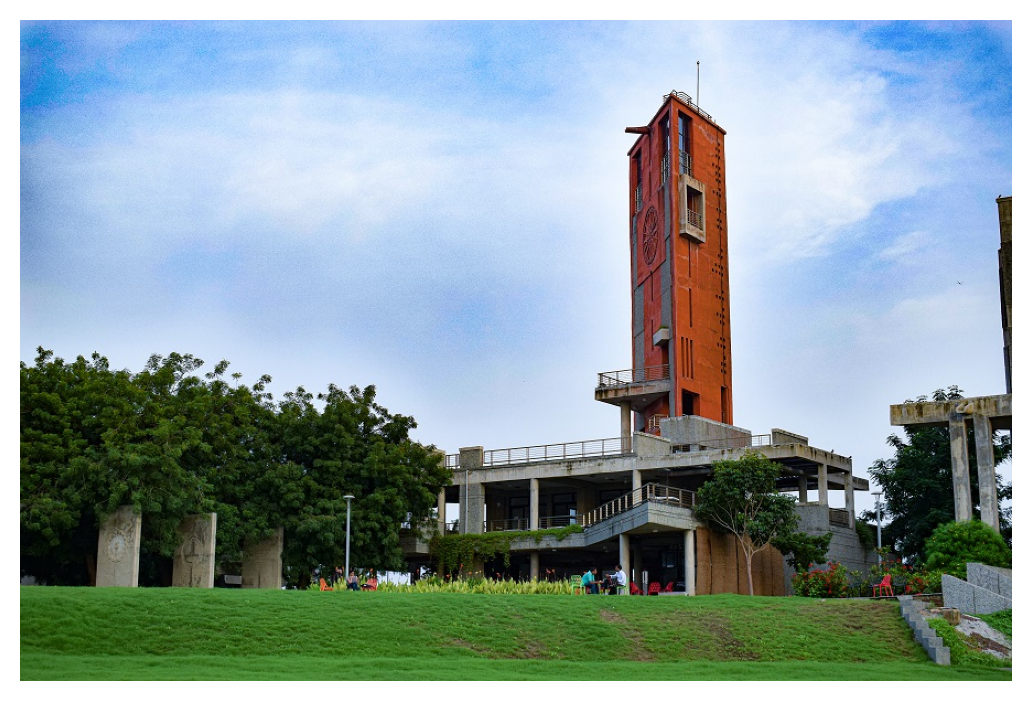

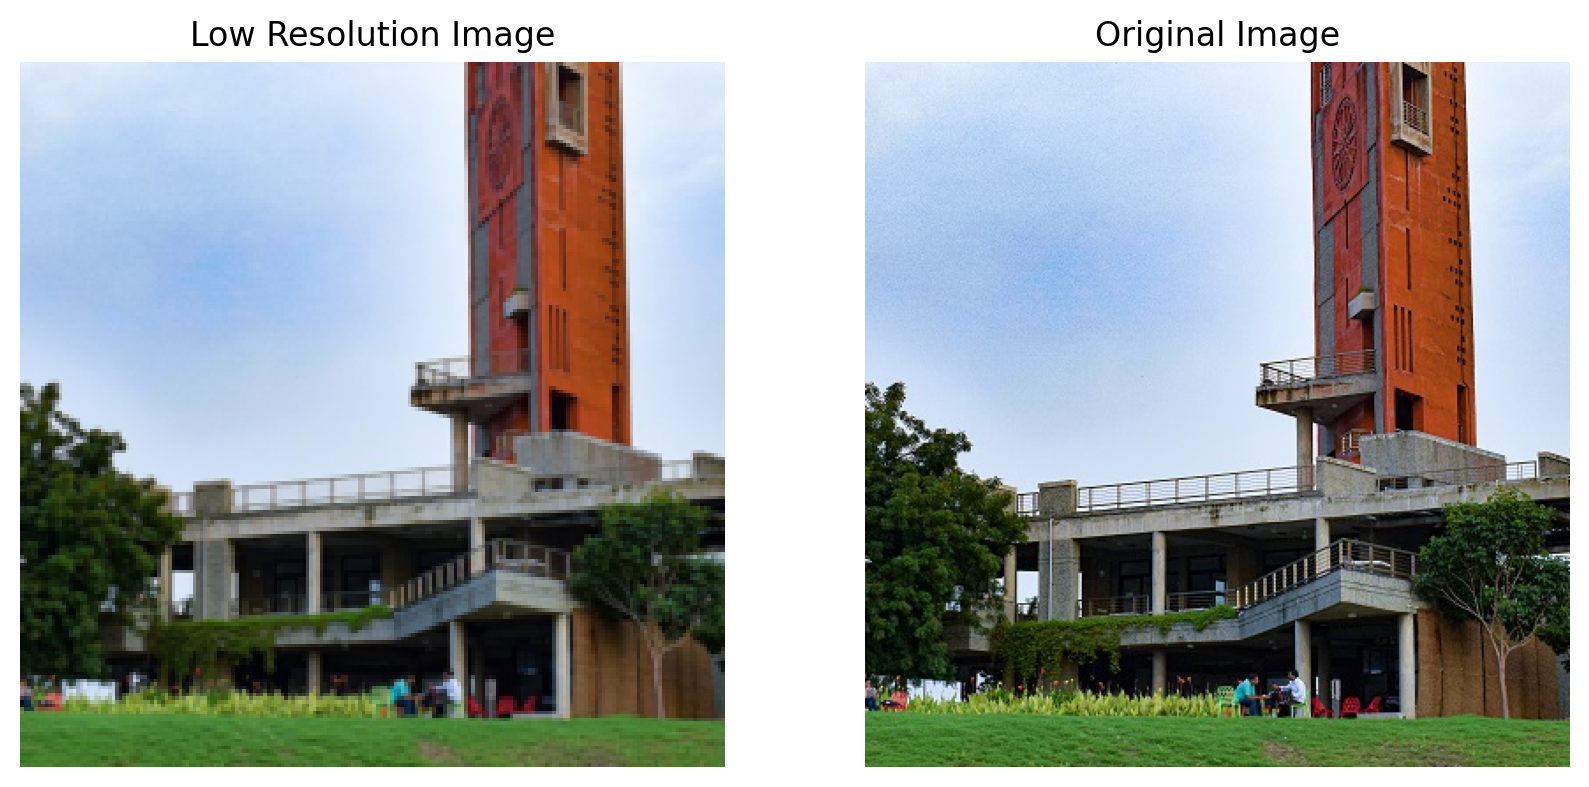

Epoch 100 loss: 0.098504
Epoch 200 loss: 0.068350
Epoch 300 loss: 0.058993
Epoch 400 loss: 0.052038
Epoch 500 loss: 0.046493
Epoch 600 loss: 0.041928
Epoch 700 loss: 0.038086
Epoch 800 loss: 0.034798
Epoch 900 loss: 0.031945
Epoch 1000 loss: 0.029445
Epoch 1100 loss: 0.027236
Epoch 1200 loss: 0.025271


KeyboardInterrupt: 

In [1]:
# %%
import torchvision.transforms.functional as TF
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

print("Import Completed")

import sys
sys.path.append("..")
from latexify import latexify, format_axes

# %%
# Set the random seed for reproducibility
torch.manual_seed(42)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")

# %%
# Read in a high-resolution image
img = torchvision.io.read_image("../assets/images/iitgn.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.axis('off')
plt.show()

# %%
from sklearn import preprocessing
# scaling the image tensor
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

# %%
img_scaled = img_scaled.to(device)
img_scaled

# %%
# Crop the image to 400x400 resolution for uniformity
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 300, 400, 400)
crop.shape

# Set the original high-resolution image to the cropped 400x400 image
original_img = crop  
low_res_img = TF.resize(original_img, [200, 200])  # Resize to 200x200

# %%
# Compare the low-res and high-res images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())
ax[0].set_title("Low Resolution Image")
ax[0].axis('off')

ax[1].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
ax[1].set_title("Original Image")
ax[1].axis('off')
plt.show()

# %%
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    X = torch.stack([h_coords.reshape(-1), w_coords.reshape(-1)], dim=1).float().to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

# %%
import torch
import sklearn.preprocessing as preprocessing

low_res_X, low_res_Y = create_coordinate_map(low_res_img)
high_res_X, _ = create_coordinate_map(original_img)

print(low_res_X.shape, low_res_Y.shape)
print(high_res_X.shape)

# Scale low-res coordinates
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_X.cpu())
low_res_X_scaled = torch.tensor(scaler_X.transform(low_res_X.cpu())).float().to(device)
high_res_X_scaled = torch.tensor(scaler_X.transform(high_res_X.cpu())).float().to(device)

# %%
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = rff.fit_transform(X.cpu().numpy())
    return torch.tensor(X, dtype=torch.float32).to(device)

# %%
X_rff_low_res = create_rff_features(low_res_X_scaled, num_features=10000, sigma=0.008)
print(X_rff_low_res.shape)
print(X_rff_low_res)

# %%
# Define a simple linear model
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

# %%
# update the train function to exit if the error is not decreasing
def train(net, lr, X, Y, epochs, verbose=True):
    losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return losses

# %%
# Initialize and train the model
model = LinearModel(X_rff_low_res.shape[1], 3)
model.to(device)
print(model)

train_loss = train(model, lr=0.005, X=X_rff_low_res, Y=low_res_Y, epochs=2000)

# Predict for high-resolution coordinates
X_rff_high_res = create_rff_features(high_res_X_scaled, num_features=10000, sigma=0.008)

# %%
# Plot training loss graph
plt.figure(figsize=(10, 5))
latexify()
format_axes(plt.gca())
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# %%
model.eval()
with torch.no_grad():
    high_res_pred_Y = model(X_rff_high_res)
    high_res_pred_Y = high_res_pred_Y.reshape(400, 400, 3).cpu().numpy()
    high_res_pred_Y = np.clip(high_res_pred_Y, 0, 1)  # Clip values to [0, 1]

# %%
# Compare the original and predicted high-resolution images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(rearrange(original_img.cpu(), 'c h w -> h w c').numpy())
ax1.set_title('Original High-Resolution Image (400x400)')

ax2.imshow(high_res_pred_Y)
ax2.set_title('Predicted High-Resolution Image')

plt.show()

# %%
from sklearn.metrics import mean_squared_error
import math

# Compute RMSE
rmse = mean_squared_error(rearrange(original_img.cpu(), 'c h w -> h w c').numpy().ravel(), high_res_pred_Y.ravel(), squared=False)

# Compute PSNR
def compute_psnr(true_img, pred_img, max_val=1.0):
    mse = mean_squared_error(true_img, pred_img)
    psnr = 20 * math.log10(max_val) - 10 * math.log10(mse)
    return psnr

psnr = compute_psnr(rearrange(original_img.cpu(), 'c h w -> h w c').numpy(), high_res_pred_Y)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")
